In [33]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import shapefile as shp
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [34]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 72                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names   = list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False 
vname     = 'vec+u+v'
year      = [1958, 2019]
mon, day, record, box, depth = None, None, None, None, None

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Transects via [ [lon], [lat], transect-name ]______________________________
input_transect = list()
input_transect.append([[-66, -66],[-67, -55], 'Drake Passage'])

# input_transect.append([[-25.5, -23.7, -23.5],[68.3, 67.5, 67.2], 'GIR'])

# input_transect.append([[-56.5,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
#                        [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
#                        'OSNAP'])
# input_transect.append([[-56.5,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0],
#                        [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4], 
#                        'OSNAP-West'])
# input_transect.append([[-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
#                        [ 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
#                        'OSNAP-East'])

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
plt_opt           = dict({'marker':'o'})
do_concat         = False 
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
do_std            = False
save_dpi          = 300
save_fmt          = ['png']
do_edgevec_r2g    = False
do_bolus          = True

# these parameters are not needed here but need to be defined for papermill 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None

In [35]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

In [36]:
#___LOAD FESOM2 MESH_______________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#__________________________________________________________________________________________________   
if n_cycl is not None: 
    cycl_s=1 if do_allcycl else n_cycl
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            # input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, n_cycl+1):
            #ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
    
#______________________________________________________________________________________________________
# # in case of diff plots
# if (ref_path is not None) and (ref_path is not "None"): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record

#______________________________________________________________________________________________________    
# # concatenate list = list1+list2
# if (ref_path is not None) and (ref_path is not "None"): 
#     if isinstance(ref_path, list): 
#         input_paths, input_names = ref_path + input_paths        , ref_name + input_names
#     else:    
#         input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_fesom2_core2_srt_dep@node_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


Drake Passage


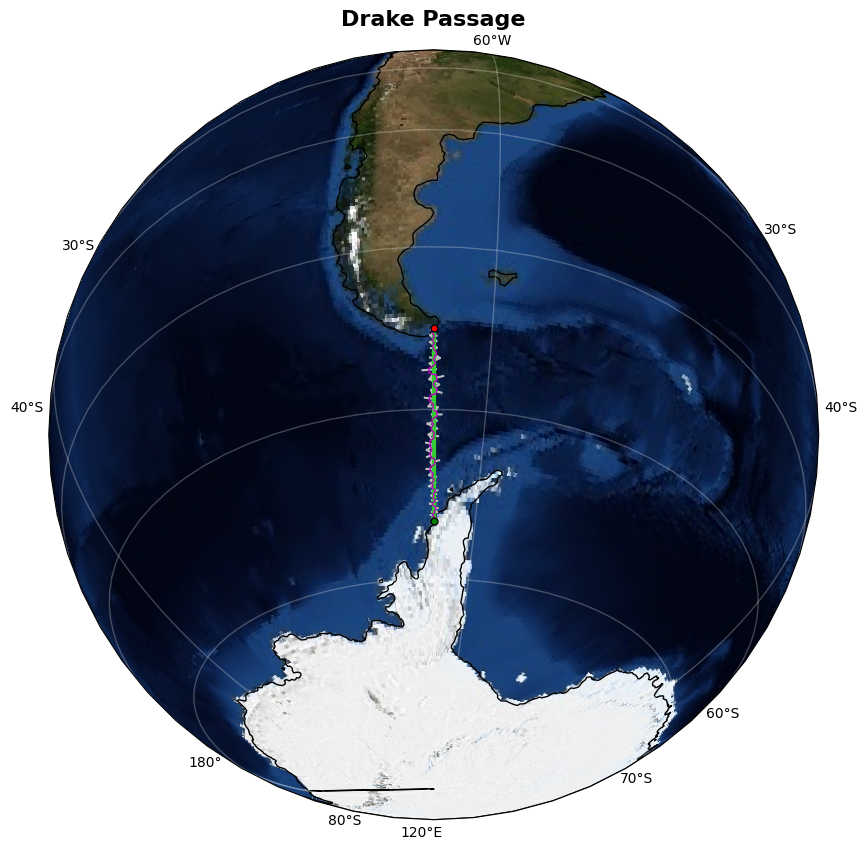

 --> elasped time: 0.039974085489908856 min.


In [37]:
#______________________________________________________________________________________________________    
# load information about edges 
ts = clock.time()
datapath = input_paths[0]
fname    = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    

#___________________________________________________________________________
# set specfic type when loading --> #convert to specific precision
# drop unnecessary variables:  Based on the documentation (but a bit hidden), 
# the "data_vars=" argument only works with Python 3.9.
from functools import partial
var_keep = ['edges', 'edge_tri', 'edge_cross_dxdy', 'nod_in_elem2D', 'edge_nodes', 'edge_face_links' ]
def _preprocess(x):
    for var in list(x.keys()):
        if var not in var_keep: 
            x = x.drop_vars(var)
            continue
            
        if x[var].dtype=='float64': x[var] = x[var].astype('float32')
        # there were some changings in the fesom.mesh.diag.nc variable naming from fesom 2.5-->2.6
        # for some reason he load now edge_nodes and edge_face_links as float32, while they cant
        # be used as indices by default and need to be converted by hand into int32
        if   var in ['edge_nodes'     ]: x = x.rename({'edge_nodes'     :'edges'})#.astype('int32')                
        elif var in ['edge_face_links']: x = x.rename({'edge_face_links':'edge_tri'})#.astype('int32')                
    return x
partial_func = partial(_preprocess)

#___________________________________________________________________________
# load diag file --> apply drop variables by preprocessor function
# decode_cf=False is need so that the original fillvalue of -999 is used instead of NaN
# or np.iinfo(np.int32).max()
mdiag = xr.open_mfdataset(os.path.join(dname,fname), parallel=False, 
                             chunks=dict({'edg_n':'auto'}), engine='netcdf4', 
                             preprocess=partial_func,  decode_cf=False)
mdiag = mdiag.drop_vars(list(mdiag.coords)).load()

# node indices of edge points [2 x n2ded]
edge       = mdiag['edges'].values-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
edge_tri   = mdiag['edge_tri'].values-1
# dx & dy of edge midpoints towards element centroid of left and right triangle
edge_dxdy  = mdiag['edge_cross_dxdy'].values[:]

# Be sure that the edge_cross_dxdy variable is in the same rotational frame as your velocities. By default
# edge_cross_dxdy is in rotated coordinates. So if you velocities are also in rotated coordinates things are fine.
# If your velocities should be in geo coordinates than edge_cross_dxdy needs to be rotated as well into geo
# coordinates (do_edgevec_r2g=True)
if (do_edgevec_r2g):
    edm_x = mesh.n_x[edge].sum(axis=0)/2.0
    edm_y = mesh.n_y[edge].sum(axis=0)/2.0
    edge_dxdy[0,:], edge_dxdy[1,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[0,:], edge_dxdy[1,:], gridis='geo', do_info=False )
    edge_dxdy[2,:], edge_dxdy[3,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[2,:], edge_dxdy[3,:], gridis='geo', do_info=False )
    del(edm_x, edm_y)
    
# [L]eft  triangle: dx, dy
edge_dxdy_l= np.array([ edge_dxdy[0,:], edge_dxdy[1,:]])
# [R]ight triangle: dx, dy
edge_dxdy_r= np.array([ edge_dxdy[2,:], edge_dxdy[3,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0. # if boundarie edge --> right triangle doesnot exist
del(edge_dxdy)

# only needed for plotting transects when scalar data are on elements 
nodeinelem = mdiag['nod_in_elem2D'].values[:,:]-1

#______________________________________________________________________________________________________    
# analyse transects computes all neccesary arrays 
transects = tpv.do_analyse_transects(input_transect, mesh, edge, edge_tri, edge_dxdy_l, edge_dxdy_r)
for transect in transects:
    print(transect['Name'])
    fig, ax = tpv.plot_transect_position(mesh, transect, edge=edge)

print(' --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))

In [39]:
data_list      = list()
data_list_plus = list()
data_list_minus= list()
year_list    = list(range(year[0], year[1]+1))
chnk_size    = 10 # compute dmoc time-series in chunks of chnk_size years
chnk_yrs_list= year_list[::chnk_size]

#___LOAD FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
for datapath, descript in zip(input_paths, input_names): 
    ts = clock.time()
    print(datapath, descript)
    print(' > year:', end='')
    
    # compute time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    transp_t, transp_t_plus, transp_t_minus = list(), list(), list()
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='\n        ')
        
        #____________________________________________________________________________________________________
        # load u and v data in rotated coordinates
        data  = tpv.load_data_fesom2(mesh, datapath, vname='vec+u+v', year=year_chnk, mon=mon, descript=descript,
                                     do_vecrot=False, do_info=False, do_tarithm=None, do_zarithm='None', 
                                     do_ie2n=False, do_nan=False, do_load=False, do_persist=True, do_parallel=do_parallel)
        #__________________________________________________________________________________________________    
        # check if data where loaded
        if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
        
        #__________________________________________________________________________________________________    
        if do_bolus:
            data_bv  = tpv.load_data_fesom2(mesh, datapath, vname='vec+bolus_u+bolus_v', 
                                         year=year_chnk, mon=mon, descript=descript,
                                         do_vecrot=False, do_info=False, do_tarithm=None, do_zarithm='None', 
                                         do_ie2n=False, do_nan=False, do_load=False, do_persist=True, do_parallel=do_parallel)
            data['u'].data += data_bv['bolus_u'].data 
            data['v'].data += data_bv['bolus_v'].data 
            del(data_bv)
        
        #____________________________________________________________________________________________________
        # compute transport through section 
        transp = tpv.calc_transect_transp(mesh, data, transects, do_info=False)
        del(data)
        
        #____________________________________________________________________________________________________
        # compute time-series
        for ii, transp_i in enumerate(transp):
            
            transp_ip = transp_i.where(transp_i['transp']>0).sum(dim=('npts','nz1'), skipna=True).rename({'transp':'transp_plus' }) 
            transp_ip['transp_plus'].attrs['long_name'] = transp_ip['transp_plus'].attrs['long_name'] + ' (+)'
            
            transp_im = transp_i.where(transp_i['transp']<0).sum(dim=('npts','nz1'), skipna=True).rename({'transp':'transp_minus'})
            transp_im['transp_minus'].attrs['long_name'] = transp_im['transp_minus'].attrs['long_name'] + ' (-)'
            
            transp_i  = transp_i.sum(dim=('npts','nz1'), skipna=True)
            
            if nchnk==0: 
                transp_t.append(transp_i)
                transp_t_plus.append(transp_ip)
                transp_t_minus.append(transp_im)
            else       : 
                transp_t[ii]       = xr.concat([transp_t[ii]      , transp_i ], dim='time')
                transp_t_plus[ii]  = xr.concat([transp_t_plus[ii] , transp_ip], dim='time')
                transp_t_minus[ii] = xr.concat([transp_t_minus[ii], transp_im], dim='time')
        
        #____________________________________________________________________________________________________
        del(transp)
    print('')    
    #____________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    data_list.append(transp_t)    
    data_list_plus.append(transp_t_plus)  
    data_list_minus.append(transp_t_minus)  
print('        elapsed time: {:3.2f}min.'.format((clock.time()-ts)/60.0))

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 > year:1958|1959|1960|1961|1962|1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972|1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982|1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992|1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002|2003|2004|2005|2006|2007
        2008|2009|2010|2011|2012|2013|2014|2015|2016|2017
        2018|2019
        
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 > year:1958|1959|1960|1961|1962|1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972|1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982|1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992|1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002|2003|2004|2005|2006|2007
        2008|2009|2010|2011|2012|2013|2014|2015|2016|2017
        2018|2019
        
/albedo/work/projects/p_feso

### --> Netto Transport

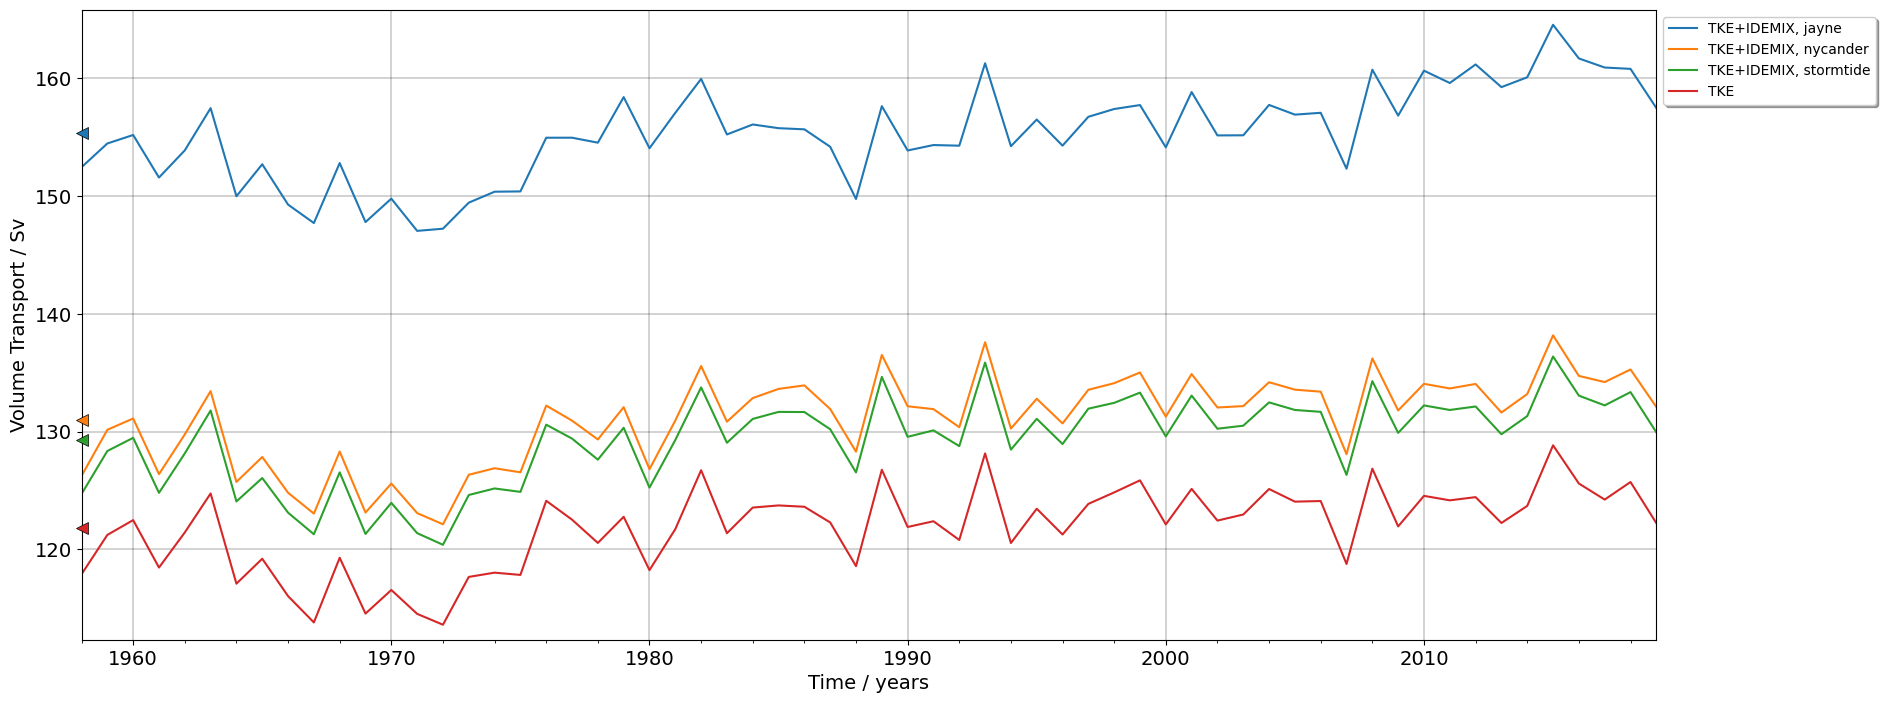

In [40]:
ntrs, ndat = len(transects), len(data_list)
for trs_idx in range(ntrs):
    
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(data_list[0][trs_idx].data_vars)[0]
    slabel = data_list[0][trs_idx][svname].attrs['str_lsave']
    stname = data_list[0][trs_idx][svname].attrs['transect_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'transect_t', stname ,slabel, sfmt)) )
    if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
   
    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(data_list, transects, nrow=1, ncol=1 , 
                            n_cycl     = n_cycl                  , 
                            do_allcycl = do_allcycl              , 
                            do_concat  = do_concat               , 
                            do_shdw    = do_shdw                 ,
                            do_mean    = do_mean                 ,
                            do_std     = do_std                  ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                            )  

### --> (+) Transport (North, East)

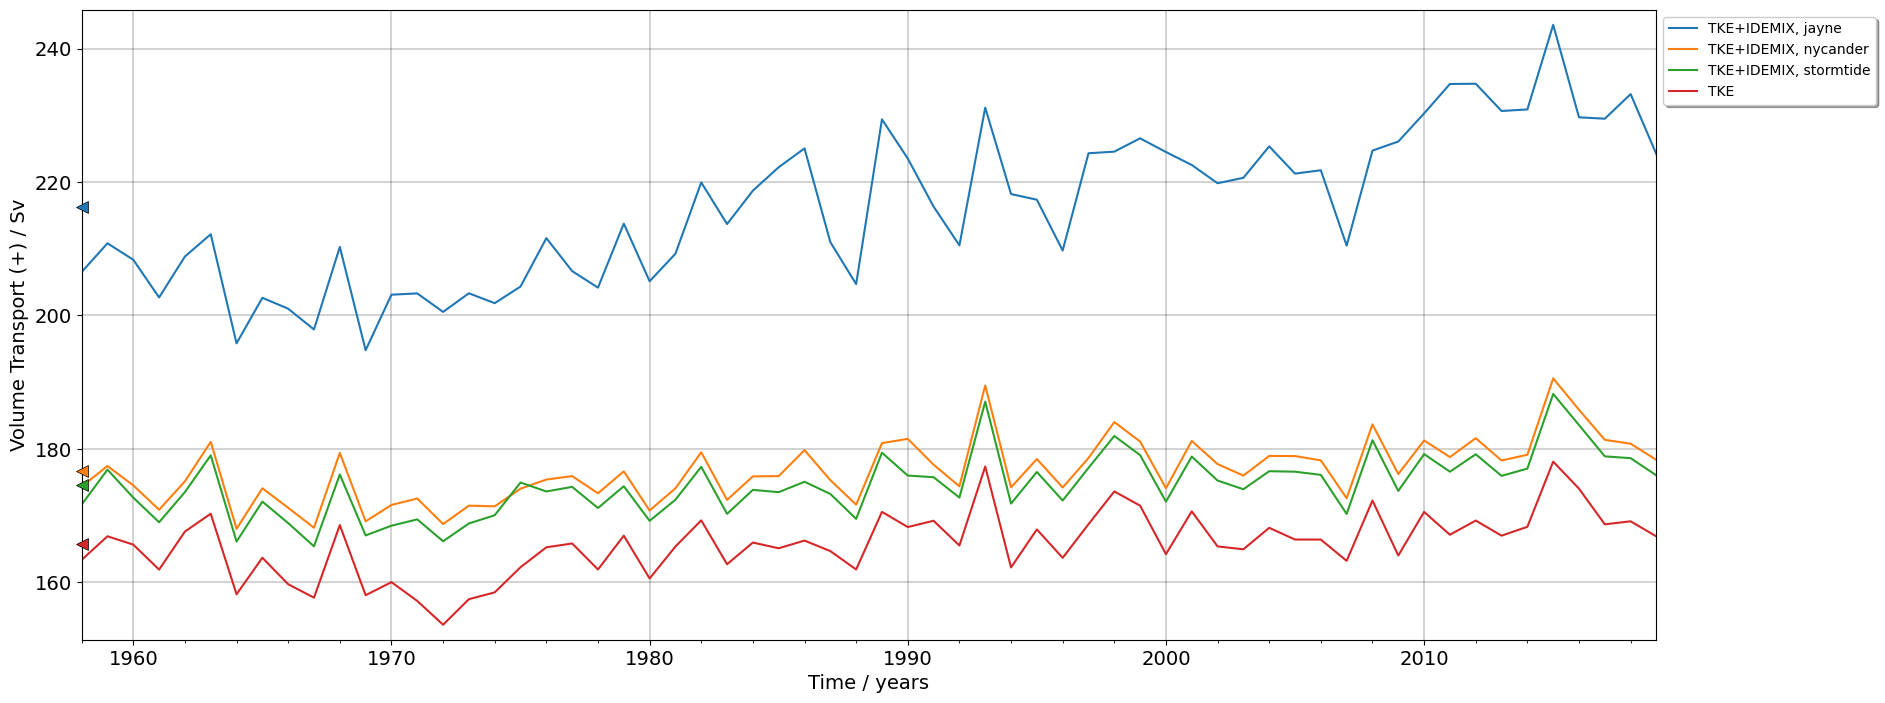

In [41]:
ntrs, ndat = len(transects), len(data_list)
for trs_idx in range(ntrs):
    
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(data_list[0][trs_idx].data_vars)[0]
    slabel = data_list[0][trs_idx][svname].attrs['str_lsave']
    stname = data_list[0][trs_idx][svname].attrs['transect_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'transect_t_plus', stname ,slabel, sfmt)) )
    if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
   
    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(data_list_plus, transects, nrow=1, ncol=1 , 
                            n_cycl     = n_cycl                  , 
                            do_allcycl = do_allcycl              , 
                            do_concat  = do_concat               , 
                            do_shdw    = do_shdw                 ,
                            do_mean    = do_mean                 ,
                            do_std     = do_std                  ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                            )  

### --> (-) Transport (South, West)

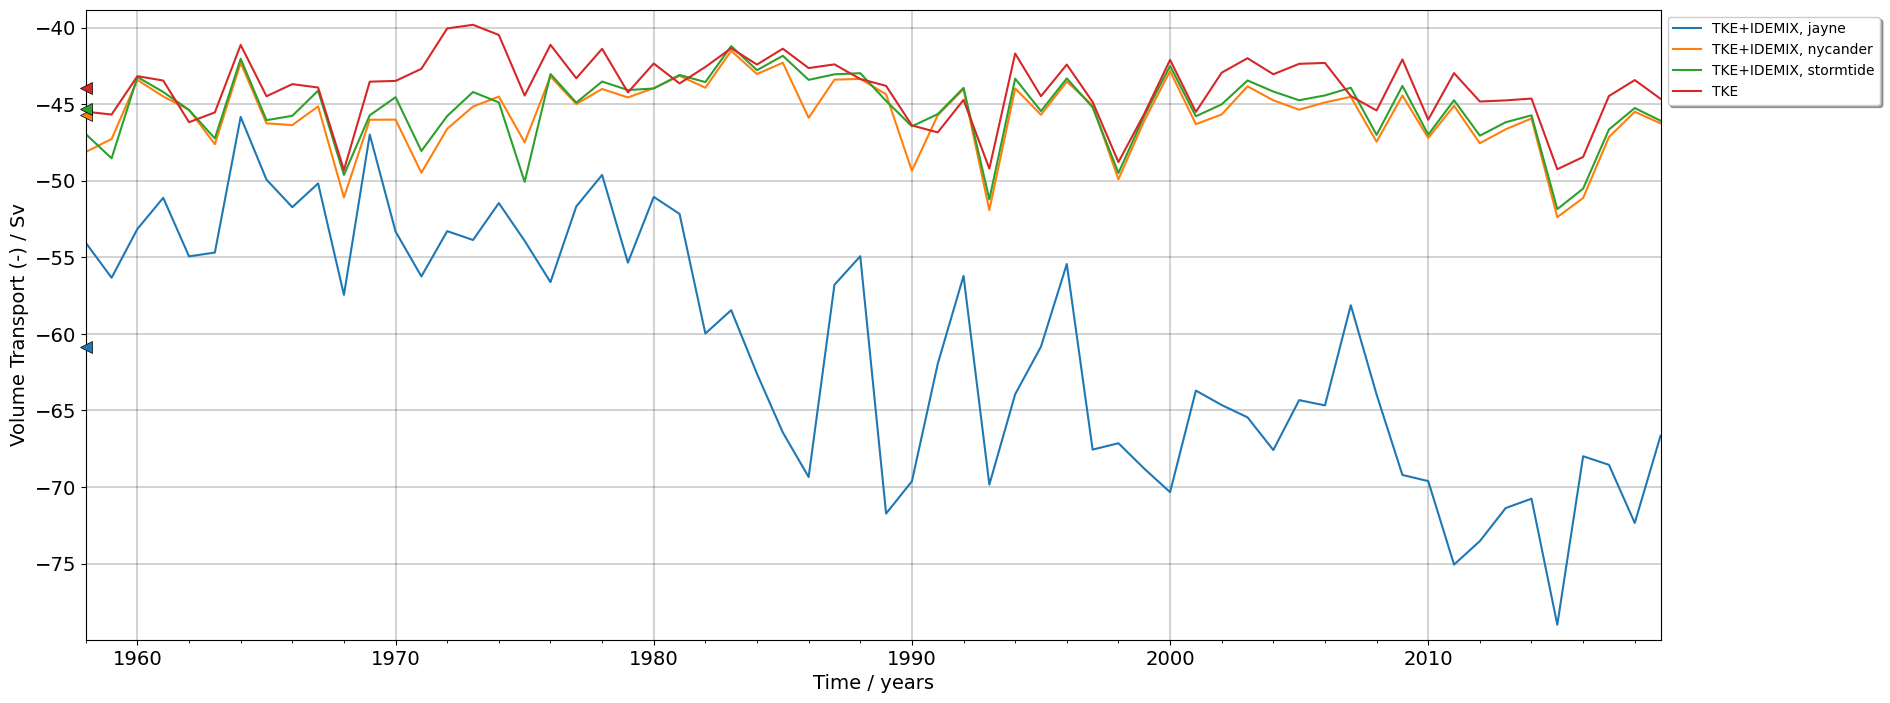

In [42]:
ntrs, ndat = len(transects), len(data_list)
for trs_idx in range(ntrs):
    
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(data_list[0][trs_idx].data_vars)[0]
    slabel = data_list[0][trs_idx][svname].attrs['str_lsave']
    stname = data_list[0][trs_idx][svname].attrs['transect_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'transect_t', stname ,slabel, sfmt)) )
    if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
   
    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(data_list_minus, transects, nrow=1, ncol=1 , 
                            n_cycl     = n_cycl                  , 
                            do_allcycl = do_allcycl              , 
                            do_concat  = do_concat               , 
                            do_shdw    = do_shdw                 ,
                            do_mean    = do_mean                 ,
                            do_std     = do_std                  ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                            )  

In [ ]:
if do_papermill and do_parallel and client_runs:
    client.shutdown()
    client_runs = False